# Extracting Data from https://www.kaggle.com/kashnitsky/news-about-major-cryptocurrencies-20132018-40k/version/2/code and preprocessing and saving onto a MongoDB database

# Sentiment Analysis using Crypto News

In [1]:
import sys
print(sys.executable)

C:\Users\lavin\anaconda3\envs\PythonData\python.exe


In [2]:
# import libraries
import pandas as pd
import numpy as np
from textblob import TextBlob
import pymongo
from pymongo import MongoClient
import certifi
from mongo2_config import mongo_uri
from wordcloud import WordCloud, STOPWORDS
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
plt.style.use('fivethirtyeight')

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk


In [3]:
# create a dataframe from the csv
path ="C:/UC_Berkeley\Analysis_Projects_Class_Folder/Module20_Final_Project\Data_Kaggle_Historical/crypto_news_parsed_2013-2018_40k.csv"
df = pd.read_csv(path)
df

,url,title,text,html,year,author,source
0,https://www.ccn.com/paris-hiltons-hotel-mogul-...,Paris Hilton’s Hotel Mogul Father to Sell $38 ...,A group of journalists who left The Denver Pos...,<p>A group of journalists who left The Denver ...,2018,Lester Coleman,accepts_bitcoin
1,https://www.ccn.com/buying-a-home-with-bitcoin...,Buying a Home With Bitcoin Makes Sense: Shark ...,Millionaire investor and Shark Tank star Barba...,<p>Millionaire investor and Shark Tank star <a...,2018,Frisco d'Anconia,accepts_bitcoin
2,https://www.ccn.com/sme-owners-in-the-uk-see-c...,UK SME Owners Anticipate Cryptocurrency Going ...,SME owners in the UK see cryptocurrency becomi...,"<p><span style=""font-weight: 400;"">SME owners ...",2018,Paul de Havilland,accepts_bitcoin
3,https://www.ccn.com/bitcoin-boost-australian-s...,‘Bitcoin Boost’: Australian State Government I...,"The government of Queensland, Australia’s seco...","<p>The government of Queensland, Australia’s s...",2018,Samburaj Das,accepts_bitcoin
4,https://www.ccn.com/bitcoin-price-too-volatile...,"Bitcoin Price Too Volatile for Merchants, Clai...",The bitcoin price is too volatile to make it a...,<p>The bitcoin price is too volatile to make i...,2018,Matt Jackson,accepts_bitcoin
...,...,...,...,...,...,...,...
39303,https://cointelegraph.com/news/senate_pressing...,Senate pressing regulators on Bitcoin risks an...,A Senate homeland security committee seeks exp...,<p>A Senate homeland security committee seeks ...,2013,Eric Barrier,regulation_news
39304,https://cointelegraph.com/news/on_the_state_of...,On the State of New York’s ‘BitLicenses’,"In mid-November, the New York State Department...","<p>In mid-November, the New York State Departm...",2013,Darya Alyokhina,regulation_news
39305,https://cointelegraph.com/news/bitcoin_s_incre...,Bitcoin’s increasing legitimacy sparks rally o...,Bitcoin traders were waiting to hear just the ...,<p>Bitcoin traders were waiting to hear just t...,2013,Eric Barrier,regulation_news
39306,https://cointelegraph.com/news/atlantis_shuts_...,"Atlantis shuts down, hindsight suggests it was...",After launching in June with a great deal of p...,<p>After launching in June with a great deal o...,2013,Eric Barrier,scam_news


In [4]:
# checking for mull values
df.isnull().sum().sum()
df.isna().sum()

url          0
title        1
text         0
html         0
year         0
author    1266
source       0
dtype: int64

In [5]:
print(df.dtypes)

url       object
title     object
text      object
html      object
year       int64
author    object
source    object
dtype: object


In [6]:
df['text'] = df['text'].astype('str')
df['title'] = df['title'].astype('str')
print(df.dtypes)

url       object
title     object
text      object
html      object
year       int64
author    object
source    object
dtype: object


In [7]:
#Create function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Create one new column called 'Polarity'
df['Polarity'] = df['text'].apply(getPolarity)

# show df with new column
df.head(5)

,url,title,text,html,year,author,source,Polarity
0,https://www.ccn.com/paris-hiltons-hotel-mogul-...,Paris Hilton’s Hotel Mogul Father to Sell $38 ...,A group of journalists who left The Denver Pos...,<p>A group of journalists who left The Denver ...,2018,Lester Coleman,accepts_bitcoin,0.077807
1,https://www.ccn.com/buying-a-home-with-bitcoin...,Buying a Home With Bitcoin Makes Sense: Shark ...,Millionaire investor and Shark Tank star Barba...,<p>Millionaire investor and Shark Tank star <a...,2018,Frisco d'Anconia,accepts_bitcoin,0.192888
2,https://www.ccn.com/sme-owners-in-the-uk-see-c...,UK SME Owners Anticipate Cryptocurrency Going ...,SME owners in the UK see cryptocurrency becomi...,"<p><span style=""font-weight: 400;"">SME owners ...",2018,Paul de Havilland,accepts_bitcoin,0.072273
3,https://www.ccn.com/bitcoin-boost-australian-s...,‘Bitcoin Boost’: Australian State Government I...,"The government of Queensland, Australia’s seco...","<p>The government of Queensland, Australia’s s...",2018,Samburaj Das,accepts_bitcoin,0.216667
4,https://www.ccn.com/bitcoin-price-too-volatile...,"Bitcoin Price Too Volatile for Merchants, Clai...",The bitcoin price is too volatile to make it a...,<p>The bitcoin price is too volatile to make i...,2018,Matt Jackson,accepts_bitcoin,0.111156


In [8]:
# Create a function to compute negative, neutral and positive sentiments
def getSentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
# Create a new column to store the sentiment
df['Sentiment'] = df['Polarity'].apply(getSentiment)

#show the df
df

,url,title,text,html,year,author,source,Polarity,Sentiment
0,https://www.ccn.com/paris-hiltons-hotel-mogul-...,Paris Hilton’s Hotel Mogul Father to Sell $38 ...,A group of journalists who left The Denver Pos...,<p>A group of journalists who left The Denver ...,2018,Lester Coleman,accepts_bitcoin,0.077807,Positive
1,https://www.ccn.com/buying-a-home-with-bitcoin...,Buying a Home With Bitcoin Makes Sense: Shark ...,Millionaire investor and Shark Tank star Barba...,<p>Millionaire investor and Shark Tank star <a...,2018,Frisco d'Anconia,accepts_bitcoin,0.192888,Positive
2,https://www.ccn.com/sme-owners-in-the-uk-see-c...,UK SME Owners Anticipate Cryptocurrency Going ...,SME owners in the UK see cryptocurrency becomi...,"<p><span style=""font-weight: 400;"">SME owners ...",2018,Paul de Havilland,accepts_bitcoin,0.072273,Positive
3,https://www.ccn.com/bitcoin-boost-australian-s...,‘Bitcoin Boost’: Australian State Government I...,"The government of Queensland, Australia’s seco...","<p>The government of Queensland, Australia’s s...",2018,Samburaj Das,accepts_bitcoin,0.216667,Positive
4,https://www.ccn.com/bitcoin-price-too-volatile...,"Bitcoin Price Too Volatile for Merchants, Clai...",The bitcoin price is too volatile to make it a...,<p>The bitcoin price is too volatile to make i...,2018,Matt Jackson,accepts_bitcoin,0.111156,Positive
...,...,...,...,...,...,...,...,...,...
39303,https://cointelegraph.com/news/senate_pressing...,Senate pressing regulators on Bitcoin risks an...,A Senate homeland security committee seeks exp...,<p>A Senate homeland security committee seeks ...,2013,Eric Barrier,regulation_news,0.091383,Positive
39304,https://cointelegraph.com/news/on_the_state_of...,On the State of New York’s ‘BitLicenses’,"In mid-November, the New York State Department...","<p>In mid-November, the New York State Departm...",2013,Darya Alyokhina,regulation_news,0.008957,Positive
39305,https://cointelegraph.com/news/bitcoin_s_incre...,Bitcoin’s increasing legitimacy sparks rally o...,Bitcoin traders were waiting to hear just the ...,<p>Bitcoin traders were waiting to hear just t...,2013,Eric Barrier,regulation_news,0.114286,Positive
39306,https://cointelegraph.com/news/atlantis_shuts_...,"Atlantis shuts down, hindsight suggests it was...",After launching in June with a great deal of p...,<p>After launching in June with a great deal o...,2013,Eric Barrier,scam_news,0.116468,Positive


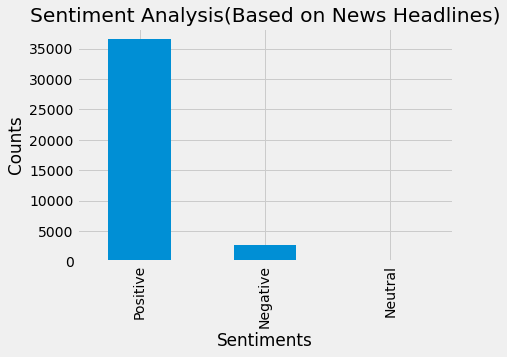

In [23]:
# Plot and visualize sentiment count
plt.title('Sentiment Analysis(Based on News Headlines)')
df["Sentiment"].value_counts().plot(kind='bar')
plt.xlabel('Sentiments')
plt.ylabel('Counts')
plt.savefig('Analysis/Sentiment Analysis(Based on News Headlines)')
plt.show()

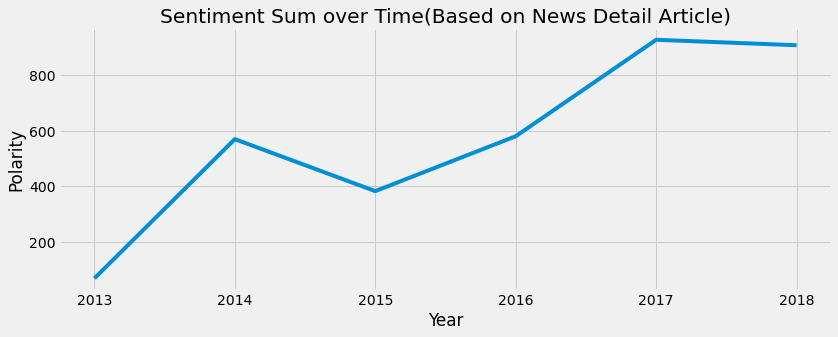

In [24]:
# Plot the sum of the polrity for each year
plt.figure(figsize=(12.33, 4.5))
plt.title('Sentiment Sum over Time(Based on News Detail Article)')
plt.xlabel('Year')
plt.ylabel('Polarity')
polarity = df.groupby(['year']).sum()['Polarity'] 
plt.plot(polarity.index, polarity)
plt.savefig('Analysis/Sentiment Sum over Time(Based on News Detail Article)')

In [11]:
# show the sum of the polarity for each year
polarity

year
2013     69.897477
2014    569.971214
2015    383.208194
2016    580.359671
2017    926.850764
2018    907.246819
Name: Polarity, dtype: float64

In [12]:
# Get the count of each article per entry
polarity_count = df.groupby(['year']).count()['Polarity']
polarity_count

year
2013      699
2014     5353
2015     4713
2016     6725
2017    10579
2018    11239
Name: Polarity, dtype: int64

In [16]:
# Show the average sentiment for each year
polarity_avg = polarity / polarity_count
polarity_avg

year
2013    0.099996
2014    0.106477
2015    0.081309
2016    0.086299
2017    0.087612
2018    0.080723
Name: Polarity, dtype: float64

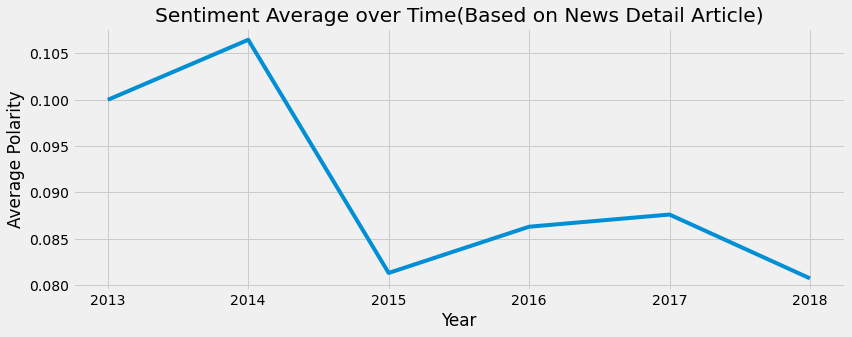

In [25]:
# Plot the average sentiment over time
plt.figure(figsize=(12.33, 4.5))
plt.title('Sentiment Average over Time(Based on News Detail Article)')
plt.xlabel('Year')
plt.ylabel('Average Polarity')
plt.plot(polarity_avg.index, polarity_avg)
plt.savefig('Analysis/Sentiment Average over Time(Based on News Detail Article)')

In [18]:
# Create a function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#Create new column 
df['Subjectivity'] = df['text'].apply(getSubjectivity)

df.head()

,url,title,text,html,year,author,source,Polarity,Sentiment,Subjectivity
0,https://www.ccn.com/paris-hiltons-hotel-mogul-...,Paris Hilton’s Hotel Mogul Father to Sell $38 ...,A group of journalists who left The Denver Pos...,<p>A group of journalists who left The Denver ...,2018,Lester Coleman,accepts_bitcoin,0.077807,Positive,0.311319
1,https://www.ccn.com/buying-a-home-with-bitcoin...,Buying a Home With Bitcoin Makes Sense: Shark ...,Millionaire investor and Shark Tank star Barba...,<p>Millionaire investor and Shark Tank star <a...,2018,Frisco d'Anconia,accepts_bitcoin,0.192888,Positive,0.395739
2,https://www.ccn.com/sme-owners-in-the-uk-see-c...,UK SME Owners Anticipate Cryptocurrency Going ...,SME owners in the UK see cryptocurrency becomi...,"<p><span style=""font-weight: 400;"">SME owners ...",2018,Paul de Havilland,accepts_bitcoin,0.072273,Positive,0.464128
3,https://www.ccn.com/bitcoin-boost-australian-s...,‘Bitcoin Boost’: Australian State Government I...,"The government of Queensland, Australia’s seco...","<p>The government of Queensland, Australia’s s...",2018,Samburaj Das,accepts_bitcoin,0.216667,Positive,0.468667
4,https://www.ccn.com/bitcoin-price-too-volatile...,"Bitcoin Price Too Volatile for Merchants, Clai...",The bitcoin price is too volatile to make it a...,<p>The bitcoin price is too volatile to make i...,2018,Matt Jackson,accepts_bitcoin,0.111156,Positive,0.400768


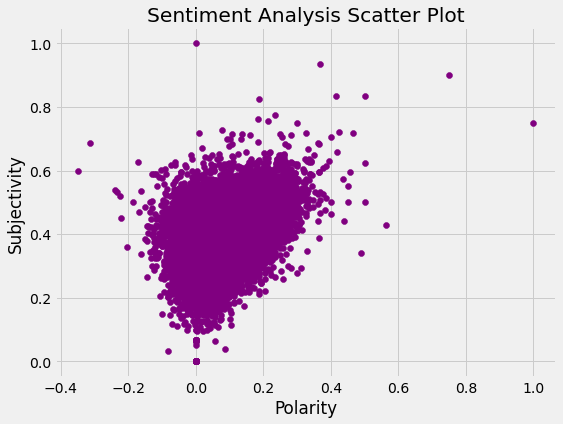

<Figure size 432x288 with 0 Axes>

In [26]:
# Create a scatter plot to show the subjectivity and the polarity
plt.figure(figsize=(8,6))
for i in range(0, df.shape[0]):
    plt.scatter(df['Polarity'][i], df['Subjectivity'][i],color= 'Purple')
plt.title('Sentiment Analysis Scatter Plot')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()
plt.savefig('Analysis/Sentiment Analysis Scatter Plot')

In [20]:
df.shape[0]

39308